# Preprocesamiento para Experimentos de Actividad Espontánea
 
Este Cuaderno es muy similar al Preprocesamiento para Evocados, pero sin promediar sobre múltiples estímulos. 
Dado que estos experimentos son muy grandes y causan problemas con el RAM, lo que vamos a hacer es primero cortarlos en cachos 
manejables (aproximadamente unos 400MB a lo más), y hacer el preprocesamiento sobre cada subarchivo.
En lugar de eso se recomienda una inspección visual para obtener un intervalo interesante del Archivo Experimental.

In [5]:
push!(LOAD_PATH, ".")
using SeparaActividadySaturados01
using HDF5, PyPlot, Statistics

┌ Info: Precompiling SeparaActividadySaturados01 [top-level]
└ @ Base loading.jl:1192
┌ Info: Recompiling stale cache file /home/karel/.julia/compiled/v1.0/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1190


La mayoría de los experimentos de actividad espontánea producen archivos de varios GB. Es imposible hacer el prerprocesamiento con 
memoría limitada. Es muy probable que haya que dividir el archivo en cachos.

In [6]:
abrestring="/home/karel/BRWFiles/estriado/estriado_slice1_1004AP.brw"
stringgeneral=replace(abrestring, ".brw"=>"")  

"/home/karel/BRWFiles/estriado/estriado_slice1_1004AP"

In [8]:
a=h5open(abrestring);
names(a)

3-element Array{String,1}:
 "3BData"    
 "3BRecInfo" 
 "3BUserInfo"

In [9]:
names(a["3BUserInfo"])

2-element Array{String,1}:
 "ExpMarkers"
 "ExpNotes"  

In [10]:
bla=read(a["3BUserInfo"]["ExpNotes"])

1-element Array{HDF5.HDF5Compound{2},1}:
 HDF5.HDF5Compound{2}(("\xc0\0\r\x04", " \0\xfa\x03"), ("Title", "Value"), (String, String))

In [12]:
tamax=400*1024*1024  #maximo tamaño tolerable de archivo en una compu de 8GB de RAM
tam=filesize(abrestring)
cachos=div(tam,tamax)+1

11

In [13]:
Datos=AbreyCheca(abrestring)

Dict{String,Any} with 8 entries:
  "minvolt"     => -4125.0
  "maxvolt"     => 4125.0
  "frecuencia"  => 17855.5
  "DatosCrudos" => UInt16[0x0000, 0x07f6, 0x080c, 0x07fe, 0x07f6, 0x07f6, 0x07f…
  "bitdepth"    => 0x0c
  "factor"      => 2.01416
  "numcuadros"  => 535665
  "duracion"    => 30.0

In [14]:
### parametetros globales.
freq=Datos["frecuencia"]/1000 #cuadros por milisegundo.
factor=Datos["factor"] #Factor de conversion de numeros enteros a microVolts
retrazo=round(Int, ceil(5*freq))
final=round(Int, ceil(60*freq))
latencia=round(Int, ceil(1.5*freq))


27

In [15]:
cuadrosmax=Datos["numcuadros"]
tiempototalms=round(cuadrosmax/freq; digits=1) 
println("Tienes ", cuadrosmax, " cuadros de muestreo a ", round(freq; digits=4), " cuadros por milisegundo")
println( "Esto corresponde a  ", tiempototalms, "ms." )

Tienes 535665 cuadros de muestreo a 17.8555 cuadros por milisegundo
Esto corresponde a  30000.0ms.


In [16]:
fmemlibre=Sys.free_memory()/Sys.total_memory()

0.6733984371105957

In [17]:
# Si los datos andan en un arreglo de lista en lugar de cuadrado, los ponemos cuadrados
if size(Datos["DatosCrudos"])[1] != 4096
DatosCrudosArreglados=reshape(Datos["DatosCrudos"], (4096, Datos["numcuadros"]))
else
DatosCrudosArreglados=Datos["DatosCrudos"]
end;

In [18]:
size(DatosCrudosArreglados)
DatosCrudosArreglados[70, 10:20]

11-element Array{UInt16,1}:
 0x07ff
 0x07f8
 0x0809
 0x0801
 0x0800
 0x07ef
 0x0803
 0x07f8
 0x0800
 0x0800
 0x0815

In [19]:
bla2(j,k)=64*(j-1)+k
bla2(33,48)


2096

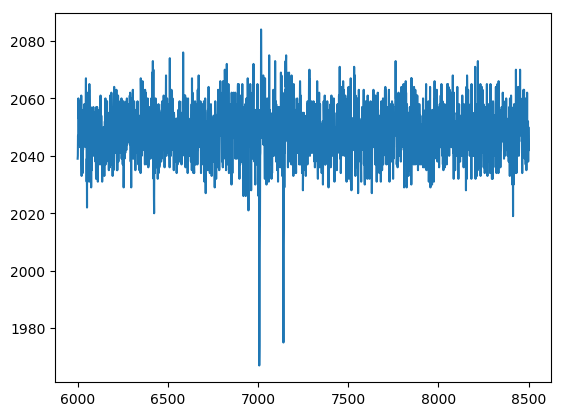

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7d2c91ca20>

In [20]:
rango=6000:8500
plot(rango, vec(DatosCrudosArreglados[2096,rango]))

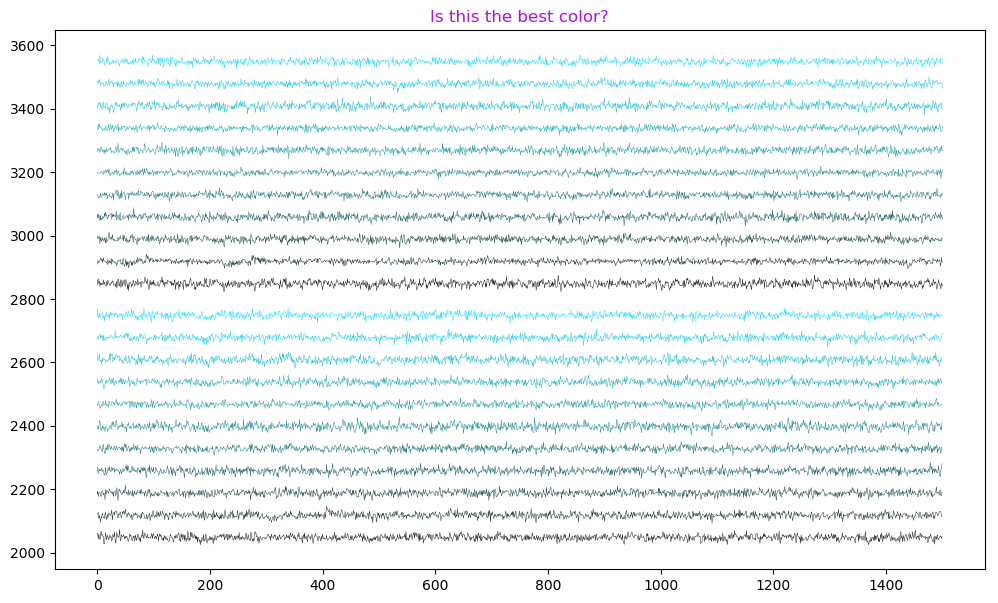

In [21]:
figure(figsize=(12,7))

title("Is this the best color?", color="#af0eee")

jmax=10

for j=0:jmax
    k=j*64+3
    plot(DatosCrudosArreglados[k,1:1500].+70*j, lw=0.3, color=(0,sin(j/jmax),j/jmax))
end


for j=0:10
    k=j*64+3
    plot(DatosCrudosArreglados[k,52000:53500].+(800+70*j), lw=0.3, color=(0,sin(j/jmax),j/jmax))
end



In [24]:
DatosCrudosArreglados[1,1]==0

true

In [25]:
cachos

11

In [27]:
# si la fraccion de memoria libre es inferior a 0.2, tenemos que cortar un cacho de los datos. Que tan chico el cacho depende... 
# toca probar
if cachos > 1
    ## escoga el usuario un cacho para trabajar entre 1 y cachos
    cacho=1
    pedazo=round(Int, Datos["numcuadros"]/cachos)
    if cacho < cachos # si no es el ultimo cacho
     DatosCrudosArreglados=DatosCrudosArreglados[:,(1+(cacho-1)*pedazo):cacho*pedazo]
    else
     DatosCrudosArreglados=DatosCrudosArreglados[:,(1+(cacho-1))*pedazo:cuadrosmax]
    end
    palabritaespecial="/Cacho_$(cacho)_"
else
    palabritaespecial="/Completo_"
end

#    end;
# Liberar memoria
#Datos["DatosCrudos"]=0
println( "Este será el identificador del archivo en cachos: ", palabritaespecial)


Este será el identificador del archivo en cachos: /Cacho_1_


In [26]:
size(DatosCrudosArreglados)

(4096, 535665)

In [27]:
 DatosCentrados=FormaMatrizDatosCentrados(DatosCrudosArreglados, factor);
# libera memoria
#DatosCrudosArreglados=0

In [28]:
ncuadros=size(DatosCentrados)[3]

535665

In [29]:
extrema(DatosCentrados)

(-4125.0, 4122.98583984375)

In [30]:
#=
function BCRP(datos::Array,freq::Number, tini=0.5,
                              tfin=8,
                              maxvolt=-100, minvolt=-1500, 
        minstd=10, maxstd=35)
    #Busquemos los canales con probable respuesta de potencial de accion
    (ancho,alto,largo)=size(datos)
    cini=round(Int, ceil(tini*freq))

    taux1=round(Int, ceil(tini*freq))
    taux2=round(Int,ceil(tfin*freq))
    
    println("Estoy buscando del cuadro " , taux1, " al , ", taux2)
    
    result=[0::Int64 0::Int64 ]
    for j=1:ancho, k=1:alto
        fondo=minimum(vec(datos[k,j,taux1:taux2]))
        dpgs=std(datos[k,j,taux1:taux2])

        if  (maxvolt >fondo>minvolt) && ( maxstd > dpgs > minstd)
            print(dpgs, " ")
            bla=[k j]
            result=vcat(result,bla)
        end
    end

    #= Esta rutina no es muy confiable. Solo da buenos resultados
    con actividad evocada. Necesitamos algo mas estricto =#
   
    return result[2:end, :]
end
=#

In [104]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
#PruebaRespuesta=BCRP(DatosCentrados,freq, 0.1,100,-100, -300)
PruebaRespuesta=BuscaCanalRespActPot(DatosCentrados,freq, 0.1,100,-85, -300, 11, 24 )
#
# y luego los saturados
iniciobusqueda=1
finbusqueda=5
Saturados=BuscaSaturados(DatosCentrados,freq, 900,iniciobusqueda,finbusqueda)
ns=size(Saturados)[1]
nr=size(PruebaRespuesta)[1]

println("Encontramos ", ns, " canales probablemente saturados.")
println("Encontramos ",  nr, " canales probablemente con actividad.")


Estoy buscando del cuadro 2 al , 1786
19.019776522827982 23.157248001273267 20.26344277825284 17.25817471136942 15.19687109407299 18.881884569162175 18.53708539919764 20.43159305808747 18.93885051501572 18.37089932463845 20.291372589262263 18.346526934794984 15.914797909352753 18.299613594255046 20.32017873848702 19.674613044114146 22.095746807654223 18.53773628034443 22.26699339055265 20.873595283679332 17.340169948046064 18.99553201700703 19.521383077825796 23.460532796763022 20.02645077457482 19.33946157752381 18.664994877832793 19.53608926907118 19.012994257010632 19.533630418946732 23.10879415536192 17.713305227386705 16.96632553452395 16.99228441841745 22.126338494383038 20.228216040844327 14.032479473792767 18.406143811967 18.991662039237 Encontramos 18 canales probablemente saturados.
Encontramos 39 canales probablemente con actividad.


In [105]:
PruebaRespuesta

39×2 Array{Int64,2}:
 30   3
 24   8
 51  14
 48  17
 45  18
 47  18
 38  19
 39  19
 44  19
 47  19
 42  20
 28  21
 29  21
  ⋮    
 33  32
 19  37
 23  45
 28  45
 31  47
 33  48
 41  48
 52  49
 21  50
 17  51
  1  55
 23  62

### inspección visual. 
Podemos tomar una imagen de la desviación estándar por canal y sobreponerle unas marcas para los canales "respuesta".
De ahí podemos tomar un ejemplo para dibujar el trazo en ese canal.

In [89]:
DesviacionPorCanal=zeros(64,64)
PromPorCanal=zeros(64,64)
cini=round(Int, 0.1*freq)
cfin=round(Int, 100*freq)
for j=1:64
    for k=1:64
        ChorizoExemplo=vec(DatosCentrados[j,k,cini:cfin])
        DesviacionPorCanal[j,k]=std(ChorizoExemplo)
        PromPorCanal[j,k]=mean(ChorizoExemplo)
    end
end


In [61]:
function desviacionventanas(data,ventmiliseg=100)
    ventana=round(Int, ventmiliseg*freq)
    longi=length(data)
    longicorrected=div(longi,ventana)
    result=zeros(longicorrected)
    for k=1:longicorrected
        result[k]=std(data[(k-1)*ventana+1:k*ventana])
    end
    return result
end

desviacionventanas (generic function with 2 methods)

In [62]:

ventmiliseg=100
ventanacuadros=round(Int,ventmiliseg*freq)
nventmax=size(DatosCentrados)[3]
nmax=div(nventmax,ventanacuadros)
sigmaventanas=zeros(64,64,nmax)

for j=1:64,k=1:64
    bla=vec(DatosCentrados[j,k,:])
    sigmaventanas[j,k,:]=desviacionventanas(bla, ventmiliseg)
end

In [63]:
extrema(sigmaventanas)
median(sigmaventanas)
median(sigmaventanas)

15.613294062530784

In [99]:
mean(PromPorCanal)
extrema(PromPorCanal)

(-4125.0, 4122.98583984375)

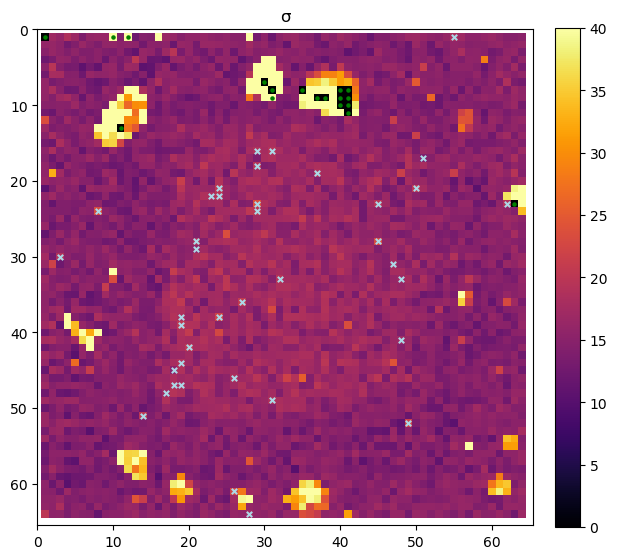

PyObject <matplotlib.collections.PathCollection object at 0x7f7c094449b0>

In [106]:
figure(figsize=(7,7))
xlim(0,65.5)
ylim(65.5,0)
title("σ")
limites=40
imagen=imshow(DesviacionPorCanal, origin="lower", interpolation="nearest",cmap="inferno", 
                      vmin=0,vmax=limites, extent=[0.5,64.5,0.5,64.5])
cb=colorbar(fraction=0.046, pad=0.04)

x=[]
y=[]
for j in 1:size(PruebaRespuesta)[1]
  append!(x,PruebaRespuesta[j,2])
   append!(y,PruebaRespuesta[j,1])
end


x2=[]
y2=[]
for j in 1:size(Saturados)[1]
  append!(x2,Saturados[j,2])
   append!(y2,Saturados[j,1])
end


scatter(x,y, marker="x",c="lightblue", s=15)
scatter(x2,y2, marker="o",c="green", s=5)

In [69]:
DesviacionPorCanal[10,37]

55.80207977649098

In [39]:
#=
ioff()
for n=1:nmax

 ioff()   
figure(figsize=(5,5))
xlim(0,65)
ylim(65,0)
title("σ ventana 100 ms")
limites=40
datos=sigmaventanas[:,:,n]
imagen=imshow(datos, origin="lower", interpolation="nearest",cmap="inferno", 
                      vmin=8,vmax=limites, extent=[0.5,64.5,0.5,64.5])
cb=colorbar(fraction=0.046, pad=0.04)

x=[]
y=[]
for j in 1:size(PruebaRespuesta)[1]
  append!(x,PruebaRespuesta[j,2])
   append!(y,PruebaRespuesta[j,1])
end


x2=[]
y2=[]
for j in 1:size(Saturados)[1]
  append!(x2,Saturados[j,2])
   append!(y2,Saturados[j,1])
end


scatter(x,y, marker="x",c="lightblue", s=10)
scatter(x2,y2, marker="o",c="green", s=3)
    
#outnmame="SigmaEstriado_Cacho_1_$n.png"    
#savefig(outnmame, dpi=90)    
    #close()
end
=#

Escogamos uno de los que parecen estar en la "sombra luminosa" del Cuerno de Amon y que estén marcados con x blanca.

In [66]:
egtrazo=DatosCentrados[10,37,:];

In [67]:
egtrazo[29000:34000];

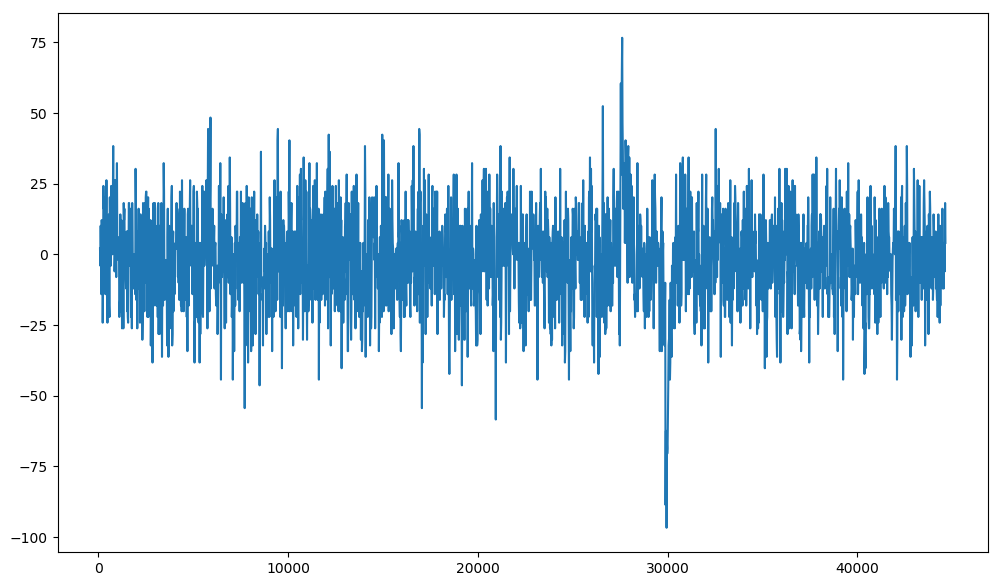

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7c091dba90>

In [110]:
figure(figsize=(12,7))
plot((5:2500).*freq, DatosCentrados[64,28,5:2500])

In [76]:
std(DatosCentrados[13,13,1:1500])

24.151584882272733

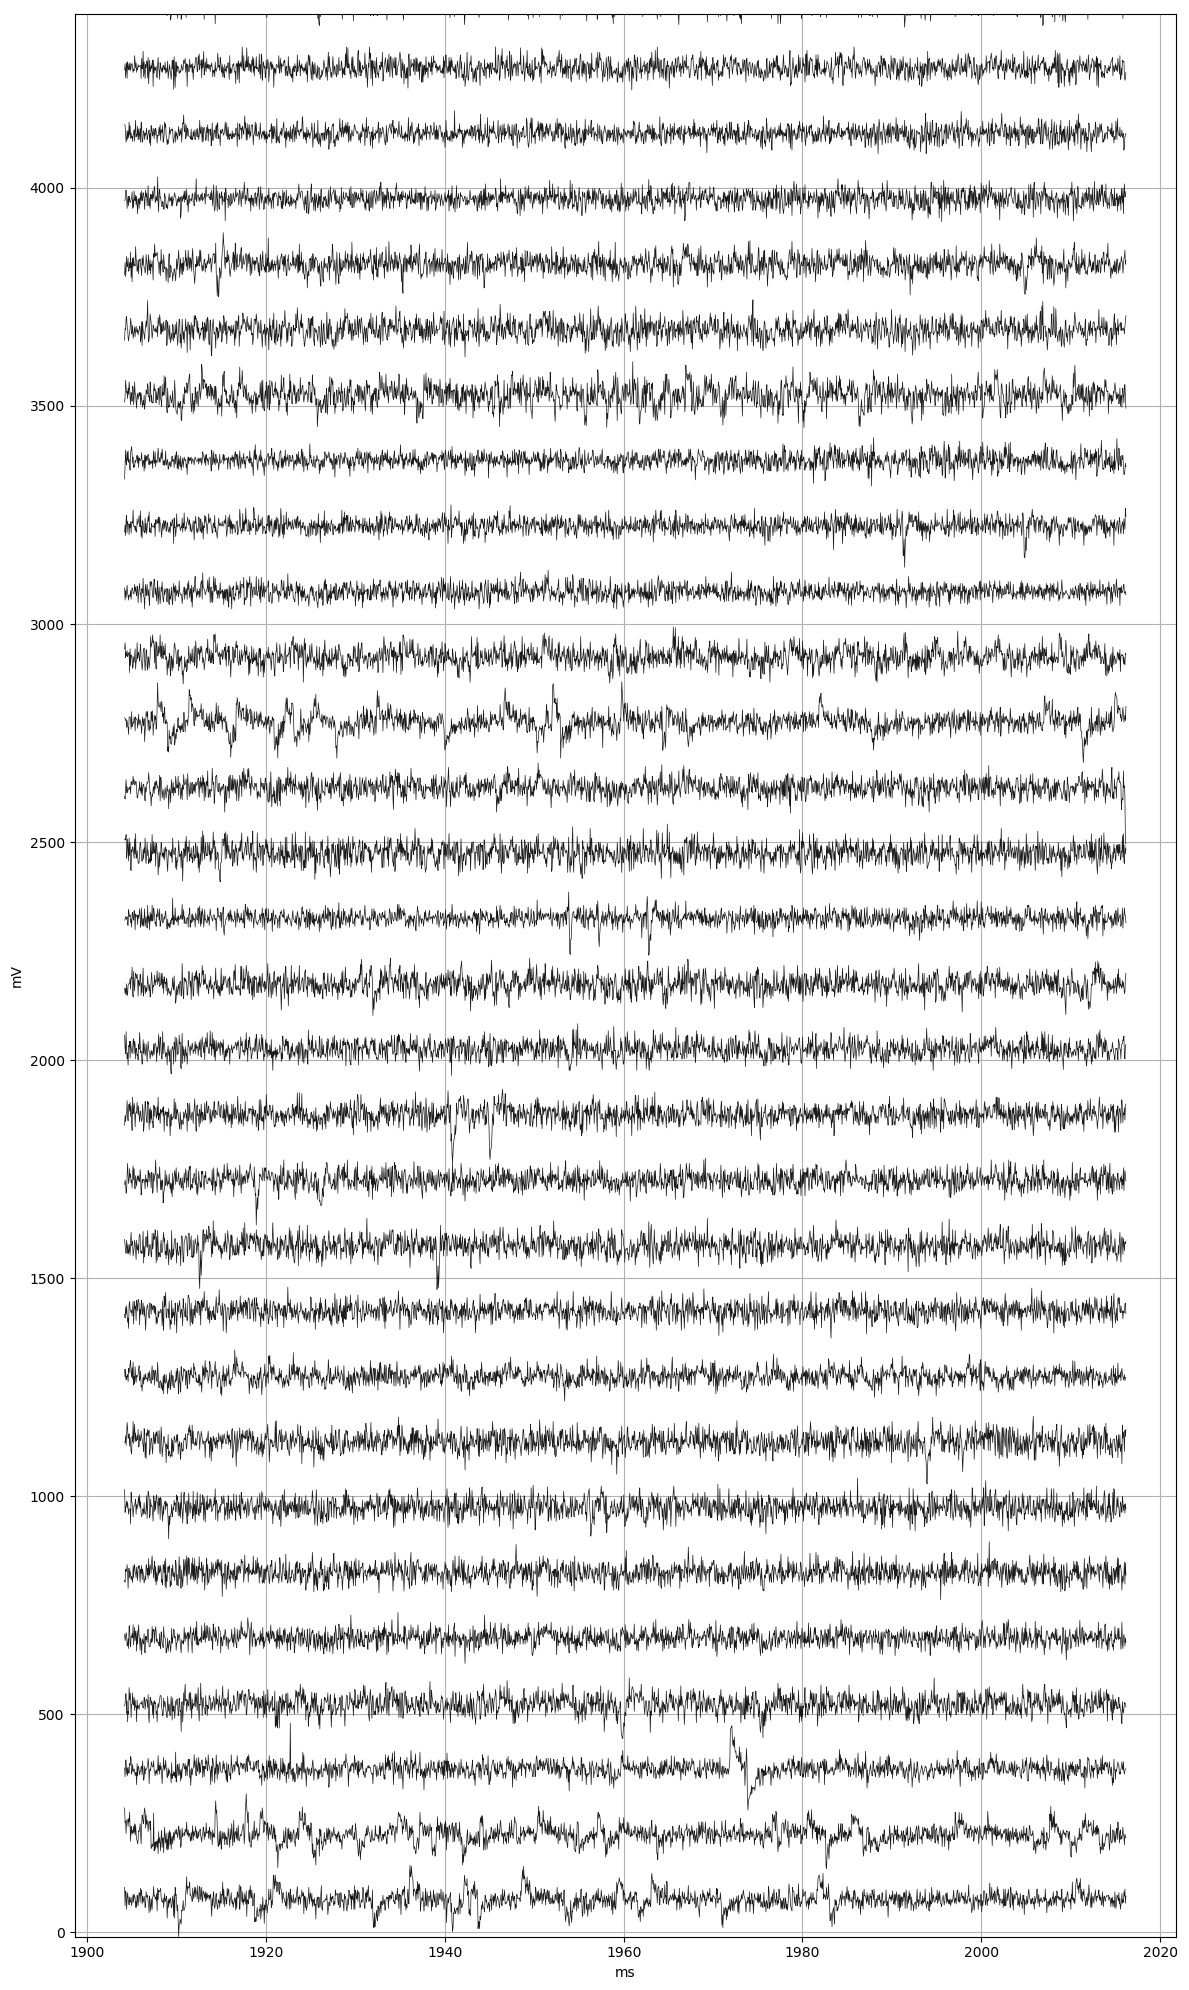

In [108]:
figure(figsize=(12,20))
xlabel("ms")
ylabel("mV")
ylim(-10,4400)

desde=34000
hasta=36000
#intervalo=1:cacho
intervalo=desde:hasta
intert=intervalo./(freq)


for j in 1:30
  l=PruebaRespuesta[j,1]
  k=PruebaRespuesta[j,2]
  egtrazo=DatosCentrados[l,k,intervalo].+(j-0.5)*150
    
    plot(intert,egtrazo, lw=0.5, c="100070")
end

bu=[1776,1796]
ba=[0,0]

bru=[1796,1796]
bra=[0,200]

#plot(bu,ba, lw=3, c="black")
#plot(bru,bra, lw=3, c="black")


#annotate("20ms", xy=(1780,20), fontsize=14)
#annotate("200mV", xy=(1797,140), fontsize=14, rotation=90)

#axis("off")
grid()

tight_layout()
#savefig("TrazosEjemploEstriado04.png", dpi=92)
#close()

Tomaremos el intervalo interesante y guardaremos esos datos en un archivo con toda la información de saturados y respuestas, 
de la misma forma que como se hace con los evocados. A diferencia de éstos, no tenemos parámetros de latencia, en lugar de eso
tendremos una indicacion de "de donde a donde se cortaron los datos", en cuadros.

In [81]:
PruebaRespuesta[1,:]

2-element Array{Int64,1}:
 30
  3

In [ ]:
dirname(stringgeneral), basename(stringgeneral)

In [ ]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
#una palabra para indicar el intervalo 
outname=string(dirgen,palabritaespecial, basegen, "tuebule.h5")
#aqui hay que arreglar el rollo del directorio

listaaguardar=Dict(
    "LFPSaturados" => DatosCentrados[:,:,desde:hasta],
     "desde" => desde,
    "hasta" => hasta,
     "freq" =>freq,
     "Canalesrespuesta" => PruebaRespuesta,
     "CanalesSaturados" => Saturados)

println(outname )
   h5open(outname, "w")  do file
        for k in keys(listaaguardar)
            datos=listaaguardar[k]
            println("abriendo los datos ", k)
            println
            write(file, "$k", datos)
        end
    end

println("hemos guardado este cacho en el archivo ", outname)

In [ ]:
typeof(listaaguardar)

In [ ]:
figure(figsize=(12,10))


rango=6000:8500
trazoejemplo=DatosCentrados[33,48,rango]

plot(rango,trazoejemplo,lw=0.2)